In [1]:
## Packages --------------------------------------------------------------------
library(CoordinateCleaner) # clean coordinartes
library(maps)
library(tidyverse) # data manipulation and visualization
library(janitor) # clear table column name
library(leaflet)
library(readxl)
library(sf)                                                                         
library(sp)
library(eks)
library(cowplot)

## Negate funcion ---------------------------------------------------------------
`%!in%` = Negate(`%in%`)

## Session info ------------------------------------------------------------------
sessionInfo()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks maps::map()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Linking to GEOS 3.12.1, GDAL 3.8.3, PROJ 9.3.1; sf_use_s2() is TRUE


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.26.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.3           eks_1.0.4               sp_2.1-3               
 [4] sf_1.0-15               readxl_1.4.3            leaflet_2.2.1          
 [7] janitor_2.2.0           lubridate_1.9.3         forcats_1.0.0          
[10] stringr_1.5.1      

In [9]:
## Import and Preprocess Lonomia Data 
# Importing the data from a Google Spreadsheet using the rio package
df_lonomia <- rio::import("https://docs.google.com/spreadsheets/d/1PzJdUGWxhmMIk8-iGw9YqTbpHNNTPvCMUJOnHefPZD0/edit?usp=sharing") |> 
  # Cleaning column names for better readability and format consistency 
  clean_names() |> 
  # Recode certain species names in the 'specie_orig' column ('Lonomia diabolus' to 'Lonomia achelous')
  mutate(specie_orig = recode(specie_orig, "Lonomia diabolus" = "Lonomia achelous")) |>
  # Filter rows based on the presence of specific substrings in the 'specie_orig' column
  filter(str_detect(specie_orig, "achelous|paraobliqua|obliqua")) |> 
  # Remove the 'specie' column from the data frame
  select(-specie) |> 
  # Rename the 'specie_orig' column to 'species'
  rename(species=specie_orig) |> 
  # Apply the next mutations on a per-row basis
  rowwise() |> 
  # Create a new 'addrs' column: concatenates different location-related fields if 'use_coordinates' is 'possible', else it's NA
  mutate(addrs = if_else(
    use_coordinates %in% "possible", 
    gsub("^,+(,+|s|-)*", "", paste(location, municipality_department, province_state, country, sep = ", ")),
    NA)) |> 
  # Perform geocoding on the 'addrs' field using OpenStreetMap (osm) method via tidygeocoder
  tidygeocoder::geocode(addrs, method = "osm")

## Process Geocoding for df_lonomia dataframe
# The following part of the script involves geocoding operations on the 'df_lonomia' dataframe

# Rename `lat...7` column to 'lat' and `long...8` to 'long'
df_lonomia <- df_lonomia |> 
  rename(lat = `lat...7`, long = `long...8`) |> 
  # Replace missing lat and long values with corresponding values from `lat...18` and `long...19`
  mutate(
    lat = if_else(is.na(lat) & !is.na(`lat...18`), `lat...18`, lat),
    long = if_else(is.na(long) & !is.na(`long...19`), `long...19`, long)
  ) |>
  # Add a new column 'coord_model' which is 1 if both lat and long are not NA, otherwise it's 0
  mutate(coord_model = if_else(!is.na(lat) & !is.na(long), 1, 0)) |> 
  # Perform geocoding on city, state, and country columns using the OpenStreetMap (osm) method via tidygeocoder
  tidygeocoder::geocode(city = municipality_department, state = province_state, country = country, method = "osm") |> 
  # Rename the resulting `lat...7` and `long...8` back to 'lat' and 'long'
  rename(lat = `lat...7`, long = `long...8`) |> 
  # Again replaces the missing lat and long values now with the corresponding values from `lat...21` and `long...22`
  mutate(
    lat = if_else(is.na(lat) & !is.na(`lat...21`), `lat...21`, lat),
    long = if_else(is.na(long) & !is.na(`long...22`), `long...22`, long)
  ) |>
  # Perform reverse geocoding on 'lat' and 'long' fields using OpenStreetMap (osm) method via tidygeocoder
  # full_results=TRUE gets the complete results from reverse geocoding 
  tidygeocoder::reverse_geocode(lat = 'lat', long = 'long', method = "osm", full_results=TRUE) |> 
  # Selecting the necessary columns from the data frame
  select(
    species, coord_model, lat = `lat...7`, long = `long...8`, month, year, municipality, 
    county, city, town, state, country = `country...6`, country_code, iso3 = `ISO3166-2-lvl4`,
    address, boundingbox, taxonomic_identification_type, taxnomer_who_identified, 
    reference, reference_type, more_info) |> 
  # Filter dataframe to keep only those cases where both 'lat' and 'long' are available
  filter(complete.cases(lat, long))

Passing 67 addresses to the Nominatim single address geocoder

Query completed in: 67.1 seconds

New names:
• `lat` -> `lat...7`
• `long` -> `long...8`
• `lat` -> `lat...18`
• `long` -> `long...19`


In [ ]:
# Coordinate Cleaning Process on the 'df_lonomia' data frame

# Use CoordinateCleaner to clean up and validate geographic coordinates in the dataframe

# clean_coordinates function is used to perform various tests and corrections on geographic coordinate datasets
# species: Column name containing species names, in this case, it's "species"
# lon: Column name containing longitude values, in this case, it's "long"
# lat: Column name containing latitude values, in this case, it's "lat"
# tests: The tests to be applied. In this case 'equal', 'seas', and 'zeros' tests are applied
  # equal: Checks for records where latitude equals longitude
  # seas: Checks for records located in the sea
  # zeros: Checks for records with zero as coordinates
# value: Determines if the cleaned or original dataset should be returned. Here we specify 'clean' so that the cleaned dataset will be returned
# report: If TRUE, it generates a report of performed tests, otherwise not. Here it is set to FALSE, so no report will be generated
dt_clean <- df_lonomia |> 
  CoordinateCleaner::clean_coordinates(
    species = "species", 
    lon = "long", lat = "lat", 
    tests = c("equal", "seas", "zeros"), 
    value = "clean", report = FALSE)

In [25]:
# Transforming and Cleaning Process on 'dt_clean' data frame
# Begin transformation with the cleaned data in 'dt_clean'
lonomie <- dt_clean |>
  # 'select' is used to select columns 'species', 'long', and 'lat' from the data
  select(species, long, lat) |>
  # 'distinct' is used to remove duplicates from the data 
  # '.keep_all = true' means all columns are retained
  distinct(.keep_all = true) |>
  # 'st_as_sf' converts simple data frames to simple feature objects
  # 'coords = c("long", "lat")' specifies which columns contain the coordinate data
  # 'crs' - Coordinate Reference System, "+proj=longlat +datum=WGS84 +no_defs" is a commonly used CRS 
  st_as_sf(coords = c("long", "lat"), crs = "+proj=longlat +datum=WGS84 +no_defs")

# Updating 'dt_clean' by converting it into a simple feature object
# This will be useful for spatial analysis or creating spatial visualizations
dt_clean <- dt_clean |> 
  # Use 'st_as_sf' to convert the dataframe into an sf (simple features) object
  # 'coords = c("long", "lat")' specifies which columns contain the coordinate data
  # 'crs' - Coordinate Reference System, "+proj=longlat +datum=WGS84 +no_defs" is a commonly used CRS
  st_as_sf(coords = c("long", "lat"), crs = "+proj=longlat +datum=WGS84 +no_defs")

In [29]:
# 'read.csv2' is used to read the file 'occ.csv' from the specified path
# 'here::here' function constructs paths relative to your project's root directory
occ <- read.csv2(here::here("data", "occ.csv")) 

# Read an excel sheet named 'survey_info_hosts' from the supplementary material using 'read_excel'
native_hst <- read_excel(here::here("data", "hosts.xlsx"), sheet = "survey_info_hosts") |> 
  # Use 'select' to keep only the desired columns: 'host_complete_name', 'native', and 'lonomia_species'
  select(host_complete_name, native, lonomia_species)

In [31]:
# Loading Spatial Data and Merging Datasets
# 'st_read' is used to read spatial data from the specified path
# 'st_transform' function is applied to transform the spatial data to a common coordinate reference system (CRS), here CRS is 4326 which represents WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS
south <- st_read(dsn = here::here("data", "South_America")) |>
            st_transform(4326)

## Merge 'occ' and 'native_hst' datasets and classify as native or exotic 
# We start with the 'occ' dataset and use 'left_join' to add data from 'native_hst'
# The join is performed on matching the 'occ' dataset's 'Taxon_name' column with 'native_hst' dataset's 'host_complete_name' column
# Use 'mutate' to add a new column 'native'. If the original 'native' value was "yes", it is replaced with "Native", otherwise, it is replaced with "Exotic"
dt_maps <- occ |> 
    left_join(native_hst, by = c("Taxon_name" = "host_complete_name")) |>
    mutate(native = ifelse(native == "yes", "Native", "Exotic")) 

Reading layer `South_America' from data source 
  `/home/jovyan/work/hospedadores_lonomia/data/South_America' 
  using driver `ESRI Shapefile'
Simple feature collection with 15 features and 1 field
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -109.4461 ymin: -58.49861 xmax: -26.24139 ymax: 12.59028
Geodetic CRS:  WGS 84


In [34]:
## denstiy kernell -------------------------------------------------------------
## based on:
## https://cran.r-project.org/web/packages/eks/vignettes/tidysf_kde.html
kern_maps <- list()

for(i in c("achelous", "obliqua")){
 
  ## density map (sf)
  krnlm <- dt_maps |> 
    filter(str_detect(native, "Native") &
               str_detect(lonomia_species, i)) |>
    select(Longitude, Latitude) |>
    as_tibble() |>
    st_as_sf(coords = c("Longitude", "Latitude"),
    crs = "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0") |>
    st_kde()
  
  maps <- krnlm$sf |>
    st_intersection(south) |>
    mutate(contlabel = as.numeric(contlabel))
    
  kern_maps[[paste0(i, "_native")]] <- maps
    
}

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [35]:
# Creating a list of Maps using ggplot
# Create an empty list `ggplants` to store the plots
ggplants <- list()

# Loop through each of the names in `kern_maps`
for(i in names(kern_maps)){
    # For each name, create a plot using ggplot
    figs_plan <- ggplot() +
        # Plot the south american spatial data with grey color
        geom_sf(data = south, fill = "grey80") + 
        # Overlay this with the specific map from kern_maps for the current index name 'i'
        # The fill parameter is set to the contlabel attribute of the dataset
        geom_sf(data = kern_maps[[i]], 
                aes(fill = contlabel), 
                alpha = 0.8, color = NA, show.legend = FALSE) +  
        # Apply gradient color scale to fill based on the value of contlabel attribute
        scale_fill_gradient2(low = "#4EA699",  # Color for low values
                             mid = "white", midpoint = 50,  # Color for mid-range values
                             high = "#ff1b6b",  # Color for high values
                             name = '%') +  # Name of legend
        # Add the borders of South American countries back on top, colored grey
        geom_sf(data = south, fill = NA, color = "grey50", size = 1.3) +
        # Set the limits for x and y coordinates
        xlim(c(-90, -30)) +
        ylim(c(-55, 12)) +  
        # Use a light theme for the plot
        theme_light() +
        # Remove axis title, test and ticks for a clean look
        theme(axis.title=element_blank(),
            axis.text=element_blank(),
            axis.ticks=element_blank())
    
    # Add the plot to the list of plots
    ggplants[[i]] <- figs_plan

}

In [37]:
# Reading and transforming data points
# Read the 'H2' sheet from lonomism_southamerica.xlsx dataset located in Scripts/datasets folder 
data_points <- read_excel(here::here("data", "lonomism_southamerica.xlsx"), sheet = "H2") |>
  # Select columns 'long' and 'lat'
  dplyr::select(long, lat) |>
  # Rename these columns to 'x' and 'y' respectively
  dplyr::rename(y = lat, x = long) |>
  # Convert dataframe into spatial points
  SpatialPoints() |>
  # Transform spatial points to sf object (Simple Features - modern standard for spatial vector data)
  st_as_sf() |> 
  # Create a buffer around each point with distance of 0.5 degrees 
  st_buffer(dist = 0.5) |> # ! 0.5 degrees
  # Combine all these buffers into a single shape
  st_union()


# Assigning a Coordinate Reference System (CRS)
# Set the CRS of the data points to WGS 84 (code: 4326), defining this spatial object to use a global latitude-longitude grid
st_crs(data_points) <- 4326

In [44]:
## Function to create a map visualization

# The function takes three arguments:
# 1. lonomia_name: the name of the Lonomia species.
# 2. lonomia_kern: Kern from the kern_maps corresponding to the provided species name.
# 3. shape_type: The unique shape identifier for the points representing the occurrences.

map_function <- function(lonomia_name, lonomia_kern, shape_type) {
  
  # Retrieve the kernel map for the specific Lonomia species
  lonomia_kern <- kern_maps[[lonomia_kern]]
  
  # Create the map visualization using ggplot
  mapita <- ggplot() +
        # Draw the base map with grey fill
        ggplot2::geom_sf(data = south, fill = 'grey') + 
        # Overlay the density kernel of the species distribution,
        # and apply a gradient color scale to visualize the density labels
        ggplot2::geom_sf(data = lonomia_kern, 
                aes(fill = contlabel), 
                alpha = 0.8, color = NA, show.legend = TRUE) + 
        scale_fill_gradient2(low = "#4EA699", 
                             mid = "white", 
                             midpoint = 50,
                             high = "#ff1b6b", 
                             name = '🌳 Kernel density') +
        # Redraw boundaries of base map for clear demarcation
        ggplot2::geom_sf(data = south, fill = NA, color = "grey50", linewidth = 1) +
        # Set range of x and y axes
        xlim(c(-90, -30)) +
        ylim(c(-55, 12)) +  
        theme_light() +
        # Plot observed data points
        ggplot2::geom_sf(data = data_points, fill = NA,  
          linewidth = 1.2, aes(colour = "Buffer")) +
        # Apply color scheme to highlight the buffer areas 
        scale_colour_manual(values = c("Buffer" = "#FF0000"), 
                        name = "🌍 Lonomism notifications") +
        # Add species occurrence points
        ggplot2::geom_sf(data = dt_clean |> filter(species %in% lonomia_name),
          aes(shape = "Lonomia"),
          size = 6, 
          fill = "#000000", 
          color = "#000000", 
          alpha = 0.7) +
        # Specify shape of these occurrence points
        scale_shape_manual(values = c("Lonomia" = shape_type), 
                     labels = c(lonomia_name),
                     name = c("🐛 Occurrences")) +
        # Theme setting and legend ordering and styling
        theme_bw(base_size = 28) +
        theme(
    # Customized visual settings for plot, including text color, legend placement, 
    # absence of axis ticks, and more.
          # [various elements omitted]	
        ) + 
        guides(fill = guide_colourbar(title.position="top", title.hjust = 0, order = 3),
         # The legend details are specified with the given customizations.
        # Ordering is given to arrange the three legends, fill (color bar), colour and shape.
         # [various elements omitted]
        ) + 
        # Adds a north arrow to the plot
        ggspatial::annotation_north_arrow(
          location = "tr", 
          which_north = "true",
          pad_x = unit(0.25, "in"), 
          pad_y = unit(0.25, "in"),
          height = unit(5, "cm"),
          width = unit(5, "cm"),
          style = ggspatial::north_arrow_nautical(
            fill = c("grey40", "white"),
            line_col = "grey20",
            text_size = 20))

  return(mapita) # End of function body by returning the created map
}

# Call the function for two species and assign the resulting maps
map_host_ach = map_function("Lonomia achelous", "achelous_native", 24) # Map for Lonomia achelous
map_host_obl = map_function("Lonomia obliqua", "obliqua_native", 25) # Map for Lonomia obliqua

In [ ]:
cowplot::plot_grid(
    map_host_ach, 
    map_host_obl, 
    labels = c("A)", "B)"), 
    label_size = 40, 
    align = "h")

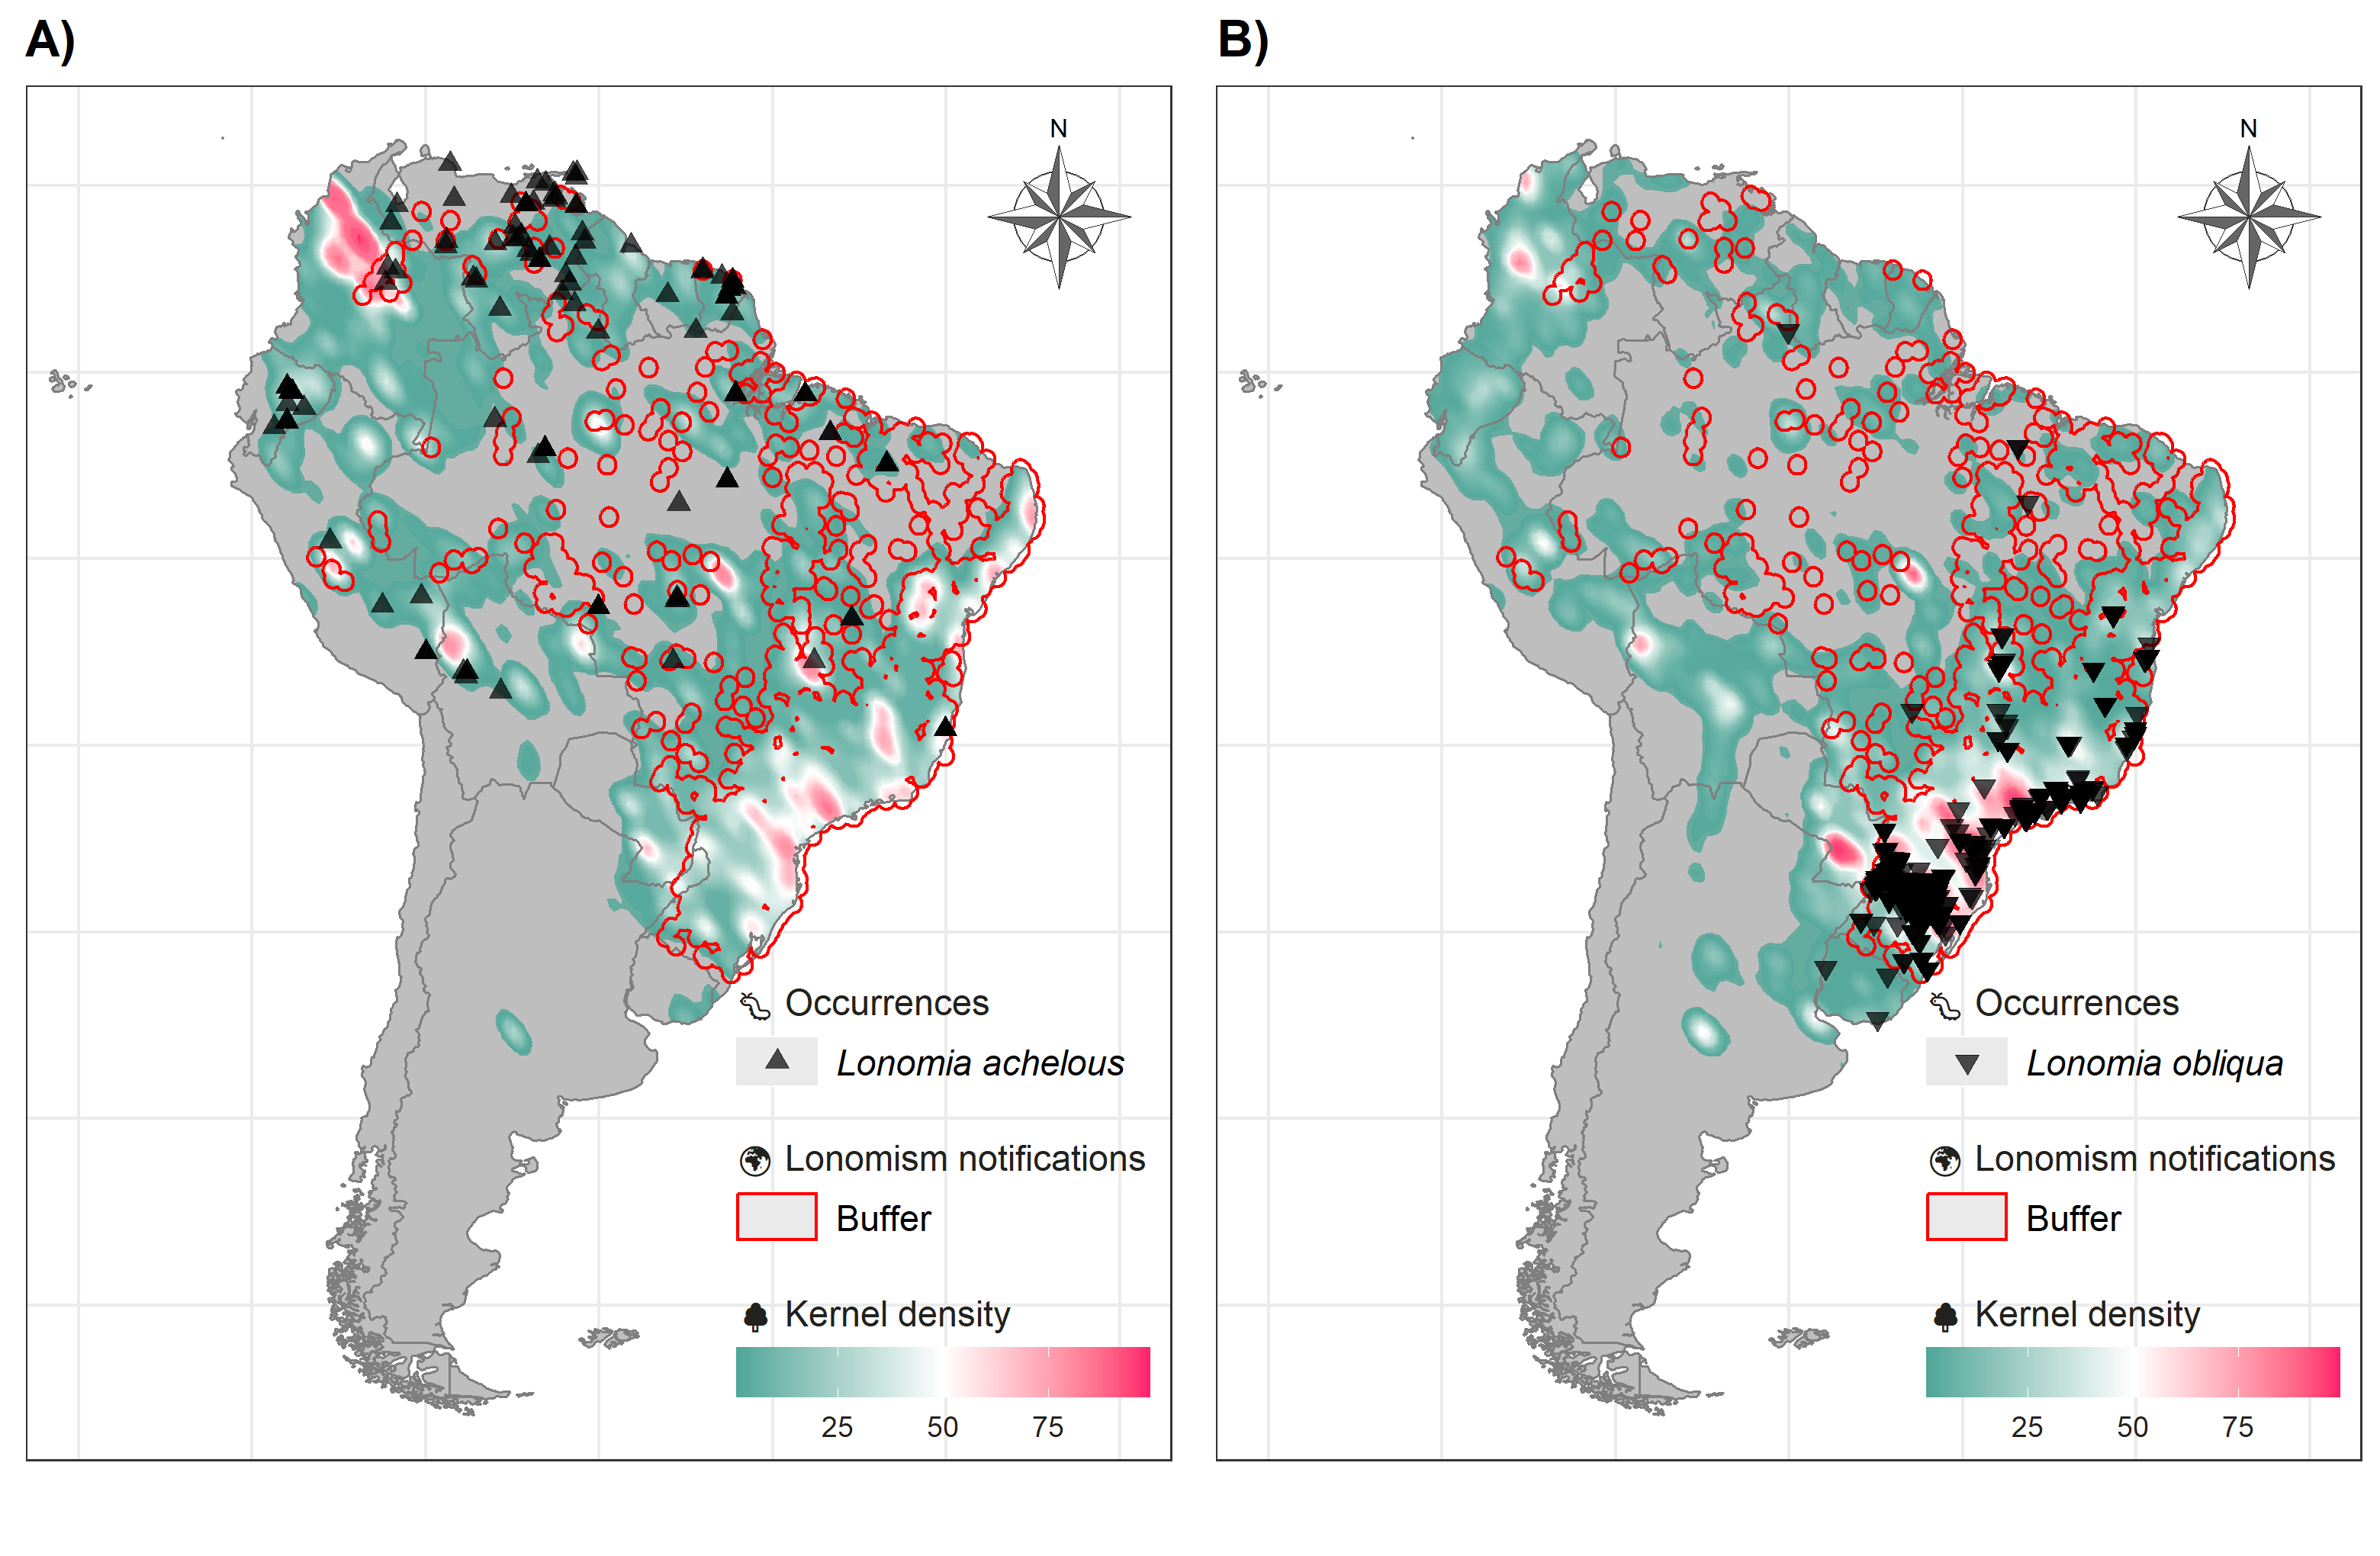